In [1]:
#### import packages ####

# os stuff
import sys
import os

#pandas and numpy
import pandas as pd
import numpy as np

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#sklearn packages
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, accuracy_score, precision_score, recall_score, classification_report

#XGBoost
import xgboost
from xgboost import XGBClassifier

#AdaBoost
from sklearn.ensemble import AdaBoostClassifier

In [2]:
#LightGBM
import lightgbm
from lightgbm import LGBMClassifier

#install and implement Catboost
!pip install catboost
import catboost
from catboost import CatBoostClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.1 MB/s eta 0:00:00


In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# set paths for preprocessor
sys.path.append('/content/drive/MyDrive/Erdos/Project/summer-2025-hoax-detection/')

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from feature_engineer import (
    VandalismScorer,
    is_IP,
    account_age,
    comment_empty,
    word_count,
)

from feature_engineer import preprocessor

In [5]:
#read the dataset
df = pd.read_csv("/content/drive/MyDrive/Erdos/Project/summer-2025-hoax-detection/Data/train.csv")
preprocessor(df)

In [6]:
#select features and target
features = ['user_edit_count','user_distinct_pages','user_warns','num_edits_5d_before',
            'is_person','current_minor','vandalism_score','account_age','comment_empty',
            'is_IP','word_count_added','word_count_deleted']
target = 'isvandalism'

In [7]:
df_tt, df_ho = train_test_split(df, test_size=0.2, random_state=42, stratify=df['isvandalism'],shuffle=True)

In [8]:
## Make Base Models
# use the results of individual runs to get the optimal hyperparameters of each
knn = KNeighborsClassifier(n_neighbors= 21, weights = 'distance', metric= 'manhattan')

svc = Pipeline([('scale', StandardScaler()),
                            ('svm', LinearSVC(C=10,max_iter=100000))])

rf = RandomForestClassifier(100,
                               max_depth = 4,
                               random_state=42)

ab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=100, random_state=42)

xgb = XGBClassifier(max_depth= 4, min_child_weight= 2,
                    gamma= 3.141595241599972, subsample= 0.818585447494315,
                    colsample_bytree= 0.7643301466688923, colsample_bylevel= 0.9834643450676969,
                    reg_alpha=0.3358100247796204, learning_rate= 0.0805746634624542, n_estimators= 916)

lgb = LGBMClassifier(learning_rate= 0.027425528114638015, num_leaves= 26, n_estimators=570, max_depth=9, verbosity=-1)

cat = CatBoostClassifier(depth= 5,
  l2_leaf_reg= 8.061754574494673,
  learning_rate= 0.019621131895883232,
  iterations= 990,
  subsample= 0.9962007205377031,
  random_strength= 0.03634375986260423,
  bagging_temperature= 0.7549103417429414,
  border_count= 91,logging_level='Silent')

In [9]:
#initialize voting classifier; pick soft voting if we want to give probabilities
#in practice, this is probably way too many models; probably drop svc to save runtime

# uncomment this block to run a voting classifier using all of them
# voting = VotingClassifier([('knn', knn),
#                            ('svc', svc),
#                            ('rf', rf),
#                            ('ab',ab),
#                            ('xgb',xgb),
#                            ('lgb',lgb),
#                            ('cat',cat)],
#                          voting='hard')

voting = VotingClassifier([('xgb',xgb),
                           ('lgb',lgb),
                           ('cat',cat)],
                         voting='hard')

Note: when running with all the classifiers, we got the following result:


```
rf_clf training set accuracy 0.88832
svc_clf training set accuracy 0.8663
knn_clf training set accuracy 0.85686
ab_clf training set accuracy 0.90779
xgb_clf training set accuracy 0.92686
lgb_clf training set accuracy 0.92489
cat_clf training set accuracy 0.92587
voting_clf training set accuracy 0.92312

Best model: xgb_clf with accuracy 0.92686
```

Based on this, we only run with xgb, lgb, and cat


In [10]:
best_name = None
best_acc = 0


# (["rf_clf",rf],
#                  ["svc_clf",svc],
#                  ["knn_clf",knn],
#                  ["ab_clf",ab],
#                  ["xgb_clf",xgb],
#                  ["lgb_clf",lgb],
#                  ["cat_clf",cat],
#                  ["voting_clf",voting])

#fit each model and print their accuracy, then print the best accuracy score
for name,clf in (["xgb_clf",xgb],
                 ["lgb_clf",lgb],
                 ["cat_clf",cat],
                 ["voting_clf",voting]):
    # fit the model
    clf.fit(df_tt[features], df_tt.isvandalism)

    # predict
    y_pred = clf.predict(df_ho[features])

    # get acc
    acc = accuracy_score(df_ho.isvandalism,y_pred=y_pred)

    print(name,"training set accuracy",np.round(acc,5))

    # update best
    if acc > best_acc:
        best_acc = acc
        best_name = name

print(f"\nBest model: {best_name} with accuracy {np.round(best_acc, 5)}")


xgb_clf training set accuracy 0.92686
lgb_clf training set accuracy 0.92489
cat_clf training set accuracy 0.92548
voting_clf training set accuracy 0.92705

Best model: voting_clf with accuracy 0.92705


Note: when running xbg and lgb with optimized hyperparameters and catboost with default parameters, we got


```
xgb_clf training set accuracy 0.92686
lgb_clf training set accuracy 0.92489
cat_clf training set accuracy 0.92587
voting_clf training set accuracy 0.92764

Best model: voting_clf with accuracy 0.92764
```



Accuracy : 0.9271
Precision: 0.9270
Recall   : 0.9229
F1 Score : 0.9249

Confusion Matrix:
[[2430  180]
 [ 191 2285]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9271    0.9310    0.9291      2610
        True     0.9270    0.9229    0.9249      2476

    accuracy                         0.9271      5086
   macro avg     0.9271    0.9269    0.9270      5086
weighted avg     0.9271    0.9271    0.9271      5086



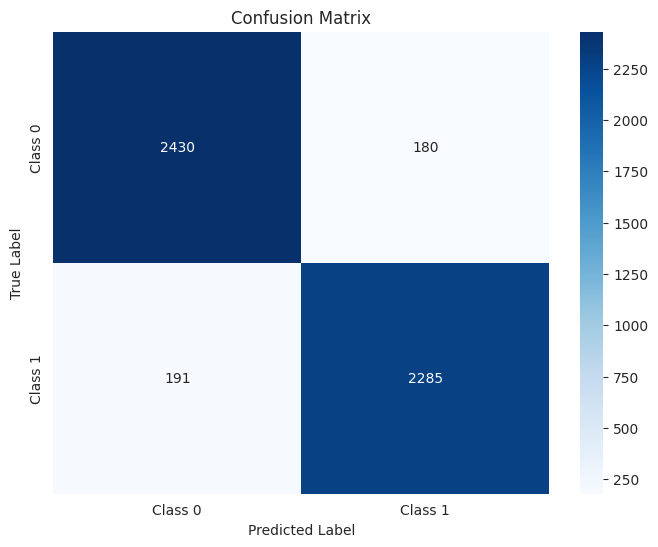

In [11]:
#Metrics for the voting classifier

# Metrics
accuracy = accuracy_score(df_ho.isvandalism, y_pred)
precision = precision_score(df_ho.isvandalism, y_pred)
recall = recall_score(df_ho.isvandalism, y_pred)
f1 = f1_score(df_ho.isvandalism, y_pred)
confmat = confusion_matrix(df_ho.isvandalism, y_pred)

# Print metrics
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nConfusion Matrix:")
print(confmat)

# Classification Report
print("\nClassification Report:")
print(classification_report(df_ho.isvandalism, y_pred, digits=4))

plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'], # Replace with your actual class labels
                yticklabels=['Class 0', 'Class 1']) # Replace with your actual class labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()